# Climate Change Classification - Sentiment analysis

## Introduction

In this predict I will try and classify Twitter users sentiment regarding climate change using machine learning models. The different classes to consider are 2: links to factual news regarding climate change, 1: supports belief of man-made climate change, 0: neither support or refutes (neutral), -1: does npd believe in man-made climate change.

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import sklearn
import sklearn.metrics
import nltk
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
daf = pd.DataFrame(y_pred_rbfsvc, columns = ['sentiment'])
daf.head()
output = pd.DataFrame({'tweetid':test['tweetid']})
submission = output.join(daf)
submission.to_csv('armand_de_wet_kaggle_classification.csv', index = False)

## Loading datasets

In [2]:
test = pd.read_csv("test.csv") # this is the testing data, i.e. tweets without the sentiment label
train = pd.read_csv("train.csv") # this is the testing data, i.e tweets with the sentiment label

In [3]:
len(train['sentiment'])

15819

## EDA

In [4]:
test.head(10)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
5,RT @nycjim: Trump muzzles employees of several...,75639
6,@bmastenbrook yes wrote that in 3rd yr Comp Sc...,211536
7,RT @climatehawk1: Indonesian farmers weather #...,569434
8,RT @guardian: British scientists face a ‘huge ...,315368
9,Aid For Agriculture | Sustainable agriculture ...,591733


In [5]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


[1, 2, 0, -1]


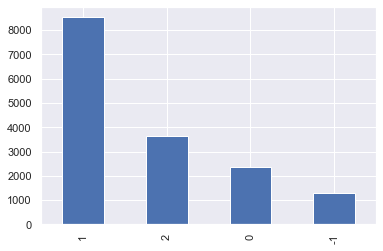

In [6]:
type_labels = list(train.sentiment.unique())
print(type_labels)
train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Clearly the data is highly imbalanced, with the '1' class being the majority class by a large margin.

## Pre-processing

Here I will proceed to clean the data in order to try and eliminate noise.

### Function to clean data

In [7]:
def cleaned_message(tweet):
    
    # convert to lower case
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

In [8]:
train['message'] =train['message'].apply(cleaned_message)

In [9]:
test['message'] =test['message'].apply(cleaned_message)

In [10]:
train.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt researchers say we have three years to act ...,698562
3,1,wired was a pivotal year in the war on climate...,573736
4,1,rt it s and a racist sexist climate change den...,466954
5,1,worth a read whether you do or don t believe i...,425577
6,1,rt mike pence doesn’t believe in global warmin...,294933
7,1,rt six big things we can all do today to fight...,992717
8,1,my yo nephew is inconsolable he wants to die o...,664510
9,1,rt no offense… but like… how do you just not b...,260471


### Tokenization

In [11]:
tokeniser = TreebankWordTokenizer()
train['message'] = train['message'].apply(word_tokenize)

In [12]:
test['message'] = test['message'].apply(word_tokenize)

In [13]:
train.head(10)

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesn, t, think, ca...",625221
1,1,"[it, s, not, like, we, lack, evidence, of, ant...",126103
2,2,"[rt, researchers, say, we, have, three, years,...",698562
3,1,"[wired, was, a, pivotal, year, in, the, war, o...",573736
4,1,"[rt, it, s, and, a, racist, sexist, climate, c...",466954
5,1,"[worth, a, read, whether, you, do, or, don, t,...",425577
6,1,"[rt, mike, pence, doesn, ’, t, believe, in, gl...",294933
7,1,"[rt, six, big, things, we, can, all, do, today...",992717
8,1,"[my, yo, nephew, is, inconsolable, he, wants, ...",664510
9,1,"[rt, no, offense…, but, like…, how, do, you, j...",260471


## Lemmatization

In [14]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Armand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Armand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
def df_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

In [16]:
train['message'] = train['message'].apply(df_lemma, args=(lemmatizer, ))
train['message'] = [' '.join(map(str, l)) for l in train['message']] 

In [17]:
test['message'] = test['message'].apply(df_lemma, args=(lemmatizer, ))
test['message'] = [' '.join(map(str, l)) for l in test['message']] 

In [18]:
train.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt researcher say we have three year to act on...,698562
3,1,wired wa a pivotal year in the war on climate ...,573736
4,1,rt it s and a racist sexist climate change den...,466954
5,1,worth a read whether you do or don t believe i...,425577
6,1,rt mike penny doesn ’ t believe in global warm...,294933
7,1,rt six big thing we can all do today to fight ...,992717
8,1,my yo nephew is inconsolable he want to die of...,664510
9,1,rt no offense… but like… how do you just not b...,260471


## Model building and testing

In [131]:
X = train['message']
y = train['sentiment']
X_test = test['message']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train

6735     [ ] climate so innovative technology to tackle...
13537    rt tillerson is moving to eliminate at least s...
6876     rt show these terrifyingly alarming photo to a...
10035    rt a majority of republican in the house and s...
5174     man stupid ã¢â‚¬â€ a powerful musical message...
                               ...                        
13418    rt russia s oil and gas industry will flourish...
5390     rt a climate change skeptic is leading trump s...
860      rt we need to tap into the science base to ena...
15795    china ’ s coal use drop showing commitment to ...
7270     rt second more than country a lot of global wa...
Name: message, Length: 12655, dtype: object

In [20]:
# Random forest
rf = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
               ('clf', MultinomialNB())])

# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
                ('clf', KNeighborsClassifier(n_neighbors=5, 
                                             metric='minkowski', 
                                             p=2))])

# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
                 ('clf', LinearSVC(class_weight='balanced'))])

# RBF SVC
rbfsvc = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
                 ('clf', SVC(class_weight='balanced'))])

In [21]:
# Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# K - nearest neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

# Linear regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

# RBF SVC
rbfsvc.fit(X_train, y_train)
y_pred_rbfsvc = rbfsvc.predict(X_valid)

In [22]:
print(metrics.classification_report(y_valid, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print(metrics.classification_report(y_valid, y_pred_nb))

              precision    recall  f1-score   support

          -1       1.00      0.09      0.16       278
           0       0.92      0.08      0.15       425
           1       0.64      0.97      0.77      1755
           2       0.87      0.53      0.66       706

    accuracy                           0.68      3164
   macro avg       0.86      0.42      0.43      3164
weighted avg       0.76      0.68      0.61      3164



In [24]:
print(metrics.classification_report(y_valid, y_pred_knn))

              precision    recall  f1-score   support

          -1       1.00      0.10      0.18       278
           0       0.92      0.11      0.20       425
           1       0.95      0.20      0.33      1755
           2       0.26      0.98      0.41       706

    accuracy                           0.35      3164
   macro avg       0.78      0.35      0.28      3164
weighted avg       0.80      0.35      0.32      3164



In [25]:
print(metrics.classification_report(y_valid, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.50      0.63      0.56       278
           0       0.46      0.58      0.51       425
           1       0.86      0.70      0.77      1755
           2       0.69      0.84      0.75       706

    accuracy                           0.71      3164
   macro avg       0.63      0.68      0.65      3164
weighted avg       0.74      0.71      0.71      3164



In [26]:
print(metrics.classification_report(y_valid, y_pred_lsvc))

              precision    recall  f1-score   support

          -1       0.58      0.54      0.56       278
           0       0.51      0.50      0.50       425
           1       0.81      0.80      0.81      1755
           2       0.74      0.78      0.76       706

    accuracy                           0.73      3164
   macro avg       0.66      0.66      0.66      3164
weighted avg       0.73      0.73      0.73      3164



In [27]:
print(metrics.classification_report(y_valid, y_pred_rbfsvc))

              precision    recall  f1-score   support

          -1       0.75      0.43      0.55       278
           0       0.50      0.52      0.51       425
           1       0.81      0.80      0.80      1755
           2       0.72      0.83      0.77       706

    accuracy                           0.74      3164
   macro avg       0.69      0.65      0.66      3164
weighted avg       0.74      0.74      0.73      3164



The RBF SVC preformed the best, so I will proceed to try and better the model's predictive ability.

## Model improvements

## SMOTE approach

I will now try and mitigate the class imbalances of the data by downsampling the majority class and upsampling the minority classes and assess whether it imroves predictive ability.

In [121]:
train_shuffled = train.sample(frac=1)
SMOTE_train = train_shuffled.sample(frac = 0.80)
SMOTE_val = train_shuffled.drop(SMOTE_train.index)

In [122]:
SMOTE_train.head(10)

,sentiment,message,tweetid
6036,1,i d say america s even stranger but the bbc gi...,41280
9998,1,rt only people in the world denying climate ch...,81773
4871,1,rt i hear the weather in alt-factistan is love...,56430
3690,1,just think -- trump still maintains that globa...,576725
3191,0,rt pmb attends a climate change conference to ...,104550
4699,0,and they say global warming s a bad thing soon...,876553
4815,2,rt these country all have climate change law,982687
15501,1,rt nyt columnist now include two white men nam...,957549
10396,1,rt why is climate change a religious issue bec...,624440
13121,0,rt problema nating lahat ang climate change pe...,445362


In [123]:
SMOTE_val.head(10)

,sentiment,message,tweetid
8357,2,rt bernie sander what astounds me is that we n...,671558
1144,-1,year of climate change in minute [ the co ha n...,920742
4809,0,rt message on climate change “ we ’ re not spe...,932957
14460,2,rt child can sue the u government over climate...,849728
3459,1,rt joint obor state read like a manifesto for ...,272240
8639,1,rt strong message to u climate change amp rene...,786181
10932,1,rt disgusting side effect of climate change,844806
4197,0,rt it s so warm outside because of climate cha...,944273
12979,1,rt so we got climate change no cure for cancer...,487280
9565,1,rt how do you talk to kid about climate change...,457788


Let us now check the data distribution of our seperated dataframes

[1, 2, -1, 0]


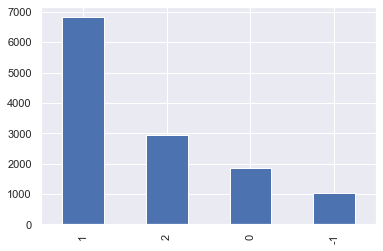

In [119]:
type_labels = list(SMOTE_train.sentiment.unique())
print(type_labels)
SMOTE_train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

[1, 0, 2, -1]


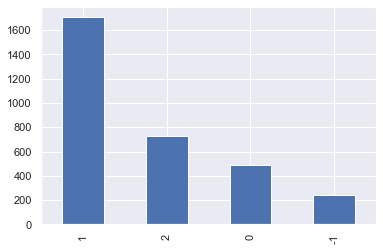

In [124]:
type_labels = list(SMOTE_test.sentiment.unique())
print(type_labels)
SMOTE_val['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Both the train and validation set have the same distribution as the original dataframe, now I will apply SMOTE on the training set in order to flatten my distribution.

In [125]:
one = SMOTE_train[SMOTE_train['sentiment']==1]
two = SMOTE_train[SMOTE_train['sentiment']==2]
zero = SMOTE_train[SMOTE_train['sentiment']==0]
min_one = SMOTE_train[SMOTE_train['sentiment']==-1]

In [126]:
print(len(one))
print(len(two))
print(len(min_one))
print(len(zero))

6825
2912
1052
1866


In [127]:
one_downsampled = resample(one,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(one)//2, # half the size of the majority class
                          random_state=41) # reproducible results

two_upsampled = resample(two,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(one)//2, 
                          random_state=41) 

zero_upsampled = resample(zero,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(one)//2, 
                          random_state=41) 

min_one_upsampled = resample(min_one,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(one)//2, 
                          random_state=41) 

# Combine 
resampled_train = pd.concat([one_downsampled, two_upsampled, zero_upsampled, min_one_upsampled])

# Check new class counts
resampled_train['sentiment'].value_counts()

 1    3412
 2    3412
 0    3412
-1    3412
Name: sentiment, dtype: int64

In [128]:
rbfsvc_resampled = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
                 ('clf', SVC())])

In [129]:
rbfsvc.fit(resampled_train['message'], resampled_train['sentiment'])
y_pred_rbfsvc = rbfsvc.predict(SMOTE_val['message'])

In [130]:
print(metrics.classification_report(SMOTE_val['sentiment'], y_pred_rbfsvc))

              precision    recall  f1-score   support

          -1       0.74      0.37      0.50       244
           0       0.60      0.41      0.49       487
           1       0.75      0.87      0.81      1705
           2       0.75      0.74      0.74       728

    accuracy                           0.73      3164
   macro avg       0.71      0.60      0.63      3164
weighted avg       0.72      0.73      0.72      3164



Resampling seems to have decreased the F1 score and hence is not a suitable method.

## Different vectorizer

In [42]:
vect = CountVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii')

In [48]:
vect.fit(X)

CountVectorizer(min_df=2, ngram_range=(1, 2), strip_accents='ascii')

In [47]:
X_train

6735     [ ] climate so innovative technology to tackle...
13537    rt tillerson is moving to eliminate at least s...
6876     rt show these terrifyingly alarming photo to a...
10035    rt a majority of republican in the house and s...
5174     man stupid ã¢â‚¬â€ a powerful musical message...
                               ...                        
13418    rt russia s oil and gas industry will flourish...
5390     rt a climate change skeptic is leading trump s...
860      rt we need to tap into the science base to ena...
15795    china ’ s coal use drop showing commitment to ...
7270     rt second more than country a lot of global wa...
Name: message, Length: 12655, dtype: object

In [49]:
X_train_vect = vect.transform(X_train)
X_valid_vect = vect.transform(X_valid)

In [50]:
X_train_vect

<12655x28255 sparse matrix of type '<class 'numpy.int64'>'
	with 313600 stored elements in Compressed Sparse Row format>

In [38]:
y_train

6735     1
13537    2
6876     1
10035    2
5174     0
        ..
13418    1
5390     1
860      1
15795    2
7270     1
Name: sentiment, Length: 12655, dtype: int64

In [51]:
rbfsvc_vect = SVC(class_weight='balanced')
rbfsvc_vect.fit(X_train_vect, y_train)

SVC(class_weight='balanced')

In [53]:
y_valid

9059     1
169      2
5331     1
6333    -1
10383    0
        ..
14706    2
7387    -1
3559     2
7401     1
3780    -1
Name: sentiment, Length: 3164, dtype: int64

In [58]:
y_pred_vect = rbfsvc_vect.predict(X_valid_vect)

In [59]:
print(metrics.classification_report(y_valid, y_pred_vect))

              precision    recall  f1-score   support

          -1       0.67      0.49      0.57       278
           0       0.42      0.56      0.48       425
           1       0.83      0.72      0.77      1755
           2       0.68      0.84      0.75       706

    accuracy                           0.71      3164
   macro avg       0.65      0.65      0.64      3164
weighted avg       0.73      0.71      0.71      3164



Decrease in accuracy.

## Removal of stop words

In [70]:
vect = TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False, stop_words = 'english')

In [71]:
vect.fit(X)

TfidfVectorizer(min_df=2, ngram_range=(1, 2), smooth_idf=False,
                stop_words='english', strip_accents='ascii')

In [72]:
X_train_vect = vect.transform(X_train)
X_valid_vect = vect.transform(X_valid)

In [73]:
rbfsvc_vect = SVC(class_weight='balanced')
rbfsvc_vect.fit(X_train_vect, y_train)

SVC(class_weight='balanced')

In [76]:
y_pred_vect = rbfsvc_vect.predict(X_valid_vect)
print(metrics.classification_report(y_valid, y_pred_vect))

              precision    recall  f1-score   support

          -1       0.72      0.43      0.54       278
           0       0.51      0.52      0.52       425
           1       0.79      0.80      0.79      1755
           2       0.70      0.77      0.73       706

    accuracy                           0.72      3164
   macro avg       0.68      0.63      0.64      3164
weighted avg       0.72      0.72      0.72      3164



Reduction in accuracy.

## Hyperparameter tuning

In [123]:
vect = TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)
vect.fit(X)
X_train_vect = vect.transform(X_train)
X_valid_vect = vect.transform(X_valid)

In [124]:
Cs = [0.001, 0.01, 0.1, 1, 10, 50]
gammas = [0.001, 0.01, 0.1, 1, 10, 'auto', 'scale']

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(class_weight='balanced'), param_grid, n_jobs = -1)
grid_SVM.fit(X_train_vect, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 50],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 'auto', 'scale']})

In [125]:
grid_SVM.best_params_

{'C': 10, 'gamma': 1}

In [126]:
y_pred = grid_SVM.predict(X_valid_vect)
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.34      0.48       278
           0       0.68      0.36      0.47       425
           1       0.75      0.92      0.83      1755
           2       0.80      0.76      0.78       706

    accuracy                           0.76      3164
   macro avg       0.76      0.60      0.64      3164
weighted avg       0.76      0.76      0.74      3164



Finally some progress, here we have about 2% increase in accuracy

## Kaggle submission

In [151]:
svc_best = Pipeline([('tfidf', TfidfVectorizer(ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)),
                 ('clf', SVC(C = 10, gamma = 1, class_weight='balanced'))])

In [152]:
X_train = X
y_train = y

In [153]:
svc_best.fit(X_train, y_train)
y_pred_best = svc_best.predict(X_test)

In [154]:
y_pred_best

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [155]:
daf = pd.DataFrame(y_pred_best, columns = ['sentiment'])
daf.head()
output = pd.DataFrame({'tweetid':test['tweetid']})
submission = output.join(daf)
submission.to_csv('armand_de_wet_kaggle_classification.csv', index = False)